# Reproducing Figure 6 from Gal and Ghahramani (2016)

This notebook reproduces Figure 6 from the paper:

**Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning**  
Yarin Gal and Zoubin Ghahramani, ICML 2016  
[arXiv:1506.02142](https://arxiv.org/abs/1506.02142)


In [2]:

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

# parameters (matching paper)
context_dim = 100
n_actions = 10
hidden_size = 50
dropout_p = 0.1
buffer_size = 30000
batch_size = 64
learning_rate = 0.001
weight_decay = 0.001
total_steps = 2000000
burn_in = 3000
random_steps = 5000
epsilon_min = 0.05

torch.manual_seed(0)
np.random.seed(0)


In [3]:

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []

    def push(self, context, action, reward):
        self.buffer.append((context, action, reward))
        if len(self.buffer) > self.capacity:
            self.buffer.pop(0)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size)
        batch = [self.buffer[i] for i in indices]
        context, action, reward = zip(*batch)
        return torch.stack(context), torch.tensor(action), torch.tensor(reward, dtype=torch.float32)

    def __len__(self):
        return len(self.buffer)


In [4]:

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_p):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_dim)
        self.dropout_p = dropout_p

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout_p, training=True)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=self.dropout_p, training=True)
        return self.out(x)


In [5]:

# true reward function 
true_weights = torch.randn(context_dim, n_actions) * 6.0

def get_reward(context, true_weights, bias=1.0):
    logits = context @ true_weights + bias
    probs = torch.sigmoid(logits)
    rewards = torch.bernoulli(probs)
    return rewards


In [6]:

def get_epsilon(step):
    return min(1.0, max(epsilon_min, 1 - (step - burn_in) / (total_steps - burn_in)))

def train_model(model, buffer, optimizer):
    if len(buffer) < batch_size:
        return
    context, action, reward = buffer.sample(batch_size)
    preds = model(context)
    pred = preds[range(batch_size), action]
    loss = F.mse_loss(pred, reward)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [7]:

model_eps = MLP(context_dim, n_actions, dropout_p)
model_ts = MLP(context_dim, n_actions, dropout_p)
opt_eps = torch.optim.SGD(model_eps.parameters(), lr=learning_rate, weight_decay=weight_decay)
opt_ts = torch.optim.SGD(model_ts.parameters(), lr=learning_rate, weight_decay=weight_decay)
buffer_eps = ReplayBuffer(buffer_size)
buffer_ts = ReplayBuffer(buffer_size)

eps_rewards, ts_rewards, batches = [], [], []

for t in range(1, total_steps + 1):
    context = torch.randn(context_dim)

    # epsilon-greedy policy
    if t < random_steps:
        action_eps = np.random.randint(n_actions)
    else:
        with torch.no_grad():
            q_vals = model_eps(context.unsqueeze(0))
        epsilon = get_epsilon(t)
        if np.random.rand() < epsilon:
            action_eps = np.random.randint(n_actions)
        else:
            action_eps = q_vals.argmax().item()

    reward_all_eps = get_reward(context, true_weights, bias=1.0)
    reward_eps = reward_all_eps[action_eps].item()
    buffer_eps.push(context, action_eps, reward_eps)
    if t > burn_in:
        train_model(model_eps, buffer_eps, opt_eps)

    # thompson Sampling policy
    if t < random_steps:
        action_ts = np.random.randint(n_actions)
    else:
        model_ts.eval()
        model_ts.train()
        q_vals = model_ts(context.unsqueeze(0))
        action_ts = q_vals.argmax().item()

    reward_all_ts = get_reward(context, true_weights, bias=1.0)
    reward_ts = reward_all_ts[action_ts].item()
    buffer_ts.push(context, action_ts, reward_ts)
    if t > burn_in:
        train_model(model_ts, buffer_ts, opt_ts)

    if t % 2000 == 0:
        batches.append(t // 2000)
        eps_rewards.append(np.mean([reward_eps]))
        ts_rewards.append(np.mean([reward_ts]))


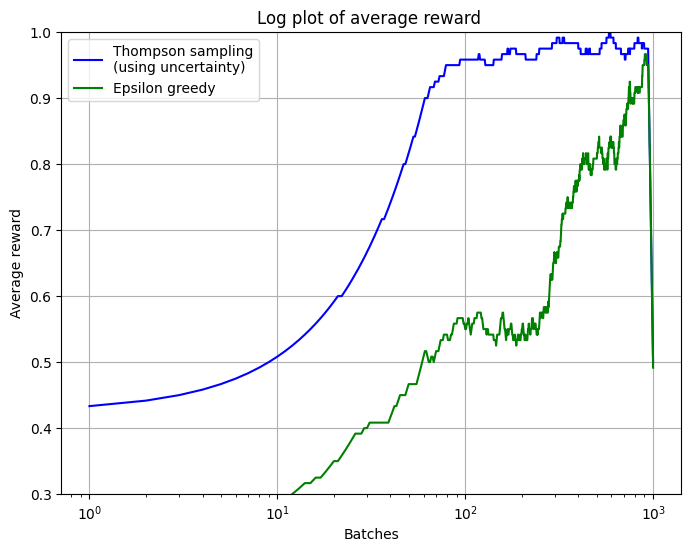

In [8]:
def smooth(y, box_size=120):
    box = np.ones(box_size) / box_size
    return np.convolve(y, box, mode='same')

ts_smooth = smooth(ts_rewards)
eps_smooth = smooth(eps_rewards)

plt.figure(figsize=(8, 6))
plt.plot(batches, ts_smooth, label="Thompson sampling\n(using uncertainty)", color='blue')
plt.plot(batches, eps_smooth, label="Epsilon greedy", color='green')
plt.xscale("log")
plt.ylim(0.3, 1)
plt.xlabel("Batches")
plt.ylabel("Average reward")
plt.legend()
plt.grid(True)
plt.title("Log plot of average reward ")
#plt.xlim(0.3, 1.1)
plt.show()
